# Analiza obrazów przy pomocy sieci konwolucyjnych

## 2.1 Ładowanie danych

In [4]:
import tensorflow_datasets as tfds

[test_set_raw, valid_set_raw, train_set_raw], info = tfds.load(
    "tf_flowers",
    split=['train[:10%]', 'train[10%:25%]', 'train[25%:]'], # odpowiedzi podizal zbioru
    as_supervised = True, # zwraane obiektty maja postac krotek zawieracych zarowno cechy jak i etykiety
    with_info = True # dodaje drugi element zwracanej krotki
)



In [5]:
class_names = info.features["label"].names
print('Class names: ',class_names)

n_classes = info.features['label'].num_classes
print('Num classes: ', n_classes)

dataset_size = info.splits['train'].num_examples
print('Dataset size: ', dataset_size)



Class names:  ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Num classes:  5
Dataset size:  3670


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import keras


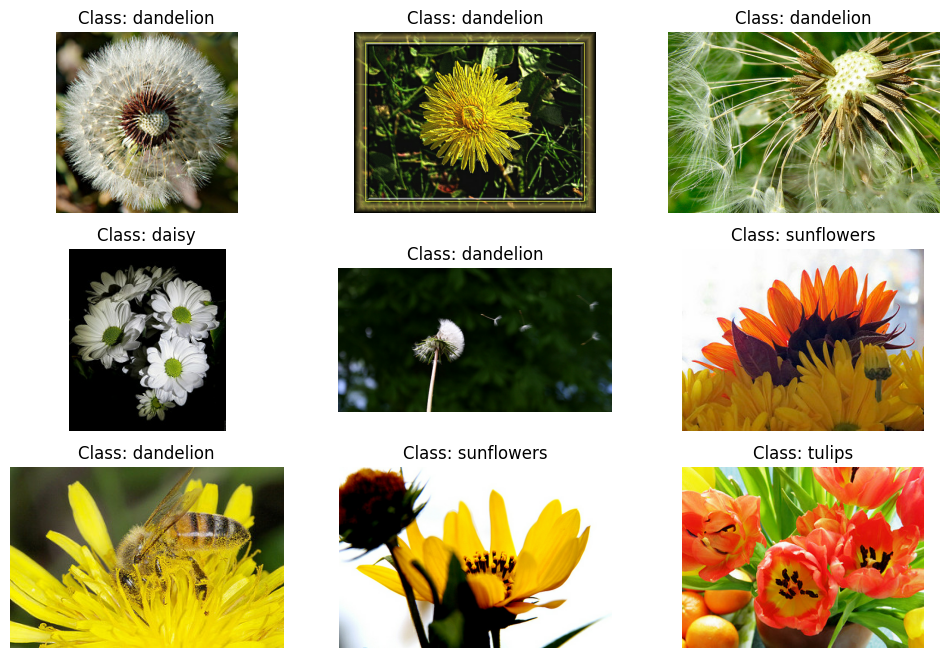

In [7]:
plt.figure(figsize=(12,8))
index = 0

sample_images = train_set_raw.take(9)


for image, label in sample_images:
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis('off')

plt.show(block=False)

## 2.2 Budujemy prostą sieć CNN

In [8]:
import tensorflow as tf

def preprocess(image, label):
    resized_image = tf.image.resize(image, [224,224])
    return resized_image, label


In [9]:
batch_size = 32

train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)


# map - stosuje funckje dla kazdego elementu w zestawie indywidualnie 
# shuffle - mieszka elementy w zestawie 
# batch - grupuje kolejne elementy w paczki (batches) o okreslonym rozmiarze 
# prefetch - pozwala na asynchroniczne przygotowanie danhych w tle,
#            gdy proces trenuje bierzaca to nastepna jest przygotowana 
#            1 okresla ze jedna paczke przygotwuje do przodu


<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


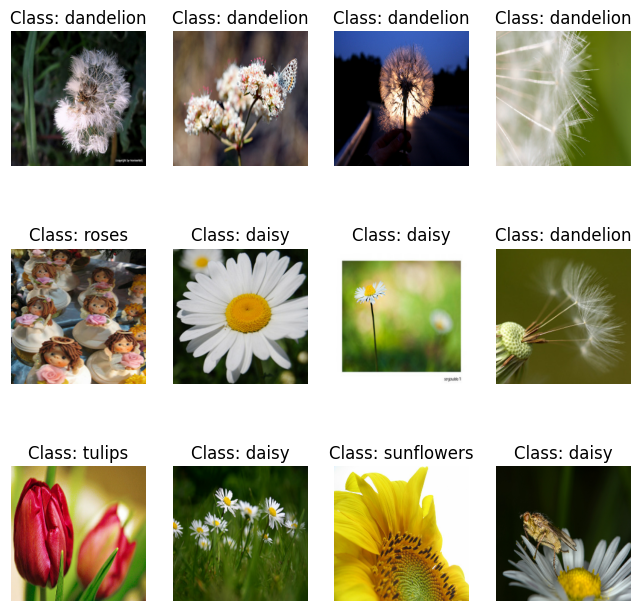

In [10]:
plt.figure(figsize=(8,8))
sample_batch = train_set.take(1)
print(sample_batch)


for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index+1)
        plt.imshow(X_batch[index]/255.0)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

## 2.2.2 Budowa sieci

In [41]:
from functools import partial
import keras

# to ustawia jakby domyslne wartosci dla Conv2D
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3,
                        activation='relu',
                        padding='SAME',
                        strides=1)


model = keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    DefaultConv2D(filters=32, kernel_size=7),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=64, kernel_size=5),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128, kernel_size=3),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(units=n_classes, activation='softmax')
])


In [49]:
optimizer = keras.optimizers.SGD(learning_rate=0.001)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        optimizer=optimizer,
                        metrics=['accuracy'])


In [43]:


history = model.fit(train_set, validation_data=valid_set,
                    epochs=10)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.3438 - loss: 1.9906 - val_accuracy: 0.2377 - val_loss: 2.0361
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.4567 - loss: 1.4299 - val_accuracy: 0.2377 - val_loss: 2.8693
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.5511 - loss: 1.1970 - val_accuracy: 0.2396 - val_loss: 2.2926
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.5883 - loss: 1.1319 - val_accuracy: 0.3811 - val_loss: 1.4167
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.6159 - loss: 1.0491 - val_accuracy: 0.4900 - val_loss: 1.2535
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.6454 - loss: 0.9667 - val_accuracy: 0.5590 - val_loss: 1.1916
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 322s 4s/step - accuracy: 0.6854 - loss: 0.8510 - val_accuracy: 0.6025 - val_loss: 1.0537
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.7040 - loss: 0.7904 - val_accuracy: 0.5917 - v

In [46]:
acc_train = model.evaluate(train_set, return_dict=True)['accuracy']
acc_test = model.evaluate(test_set, return_dict=True)['accuracy']
acc_valid = model.evaluate(valid_set, return_dict=True)['accuracy']

print('Train accuracy : ', acc_train)
print('Test accuracy : ', acc_test)
print('Valid accuracy : ', acc_valid)

result1 = (acc_train, acc_valid, acc_test)



86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 462ms/step - accuracy: 0.8786 - loss: 0.4089
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step - accuracy: 0.6594 - loss: 0.9399
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 434ms/step - accuracy: 0.6148 - loss: 1.0245
Train accuracy :  0.8815407156944275
Test accuracy :  0.6893733143806458
Valid accuracy :  0.6098003387451172


In [50]:
with open('simple_cnn_acc.pkl', 'wb') as file:
    pickle.dump(result1, file)

model.save('simple_cnn_flowers.keras')

## 2.3 Uczenie transferowe

In [11]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label



In [12]:
batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)


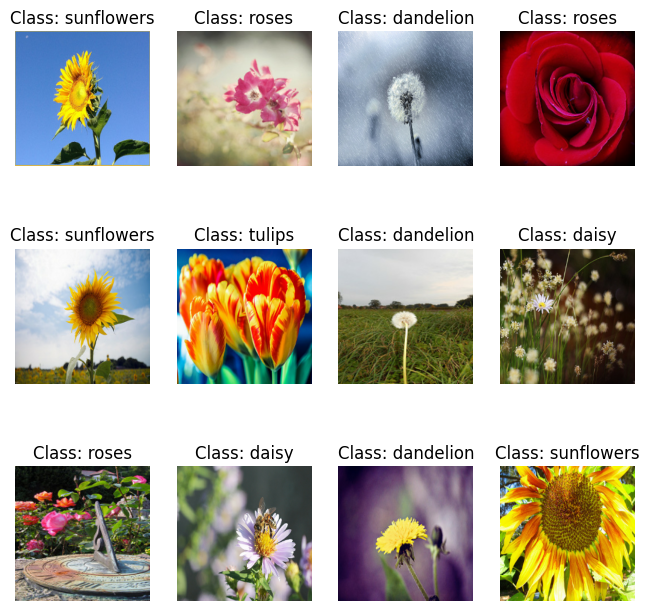

In [13]:
plt.figure(figsize=(8,8))
sample_batch = train_set.take(1)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3,4, index+1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis('off')

plt.show()

In [14]:
base_model = tf.keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False
)

# weights - zapewnia inicjalizajce wag sieci wynikami uczenia ImageNet
# include_top - znaczy ze siec nie posiadac gornych warstw sepcyficznych
#               dla danego problemu, sami musimy je dodac

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [22]:
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

## Wstepne przyuczanie

In [23]:
# blokujemy narazie warstwy modleu bazowego

for layer in base_model.layers:
    layer.trainable = False
    

In [24]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9,
                                 decay=0.01)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=['accuracy'])

c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [25]:
history = model.fit(train_set, validation_data=valid_set,
                    epochs=5)

Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 245s 3s/step - accuracy: 0.7011 - loss: 1.5487 - val_accuracy: 0.8385 - val_loss: 1.3151
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1498s 18s/step - accuracy: 0.9169 - loss: 0.5007 - val_accuracy: 0.8276 - val_loss: 1.5185
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 323s 4s/step - accuracy: 0.9122 - loss: 0.5154 - val_accuracy: 0.8149 - val_loss: 1.5469
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 365s 4s/step - accuracy: 0.9493 - loss: 0.2400 - val_accuracy: 0.8348 - val_loss: 1.1688
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 460s 5s/step - accuracy: 0.9629 - loss: 0.1620 - val_accuracy: 0.8439 - val_loss: 1.2459


## Uczenie zasadnicze

In [28]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                 nesterov=True, decay=0.0001)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=5)

Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1687s 19s/step - accuracy: 0.9354 - loss: 0.2273 - val_accuracy: 0.8766 - val_loss: 0.3623
Epoch 2/5
15/86 ━━━━━━━━━━━━━━━━━━━━ 21:29 18s/step - accuracy: 0.9856 - loss: 0.0789

KeyboardInterrupt: 

In [ ]:
acc_train = model.evaluate(train_set, return_dict=True)['accuracy']
acc_test = model.evaluate(test_set, return_dict=True)['accuracy']
acc_valid = model.evaluate(valid_set, return_dict=True)['accuracy']

print('Train accuracy : ', acc_train)
print('Test accuracy : ', acc_test)
print('Valid accuracy : ', acc_valid)

result2 = (acc_train, acc_valid, acc_test)

In [ ]:
with open('xception_acc.pkl', 'wb') as file:
    pickle.dump(result2, file)

model.save('xception_flowers.keras')